### Importing libraries

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn import metrics
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.mixture import GaussianMixture

### Loading the dataset

In [7]:
lloyds_users_df = pd.read_csv('Lloyds_users.csv')

In [8]:
lloyds_users_df

,user_id,total_tx_count,net_tx_count,total_tx_sum_gbp,net_tx_sum_gbp,sent_tx_count,sent_tx_sum_gbp,sent_tx_mean_gbp,sent_tx_median_gbp,received_tx_count,...,user_biz_interaction_frequency,user_biz_spend,user_user_interaction,user_user_interaction_frequency,user_user_spend,user_industry_interaction,user_industry_interaction_frequency,user_industry_spend,user_date_transaction,user_date_transaction_freq
0,1000,1903,1517,37720.11,19676.91,1710,28698.51,16.782754,4.50,193,...,"[116, 117, 2, 72, 5, 9, 19, 1, 35, 119, 1, 2, ...","[278.15, 269.25, 217.86, 850.5, 19.5, 347.15, ...","['16354', '18013', '30208', '31489', '36647', ...","[55, 14, 6, 12, 1, 14, 5, 14, 1, 18, 21, 1, 27...","[315.4, 86.5, 35.0, 16130.0, 5.0, 94.0, 24.0, ...","['Alcohol', 'Apparel', 'Books', 'Cafes', 'Chil...","[3, 1, 1, 813, 2, 3, 37, 1, 7, 2, 30, 21, 353,...","[114.97999999999999, 145.0, 8.0, 1955.2, 160.0...","['01/01/2025', '01/02/2025', '01/03/2025', '01...","[5, 5, 13, 6, 2, 9, 5, 8, 6, 5, 5, 7, 4, 7, 2,..."
1,10000,1114,720,21360.39,18944.39,917,20152.39,21.976434,11.00,197,...,"[6, 1, 16, 71, 59, 3, 9, 7, 33, 2, 22, 7, 9, 2...","[13.65, 2.25, 349.77, 791.0, 1275.25, 12.5, 27...","['15896', '28620', '33124', '33732', '34123', ...","[39, 49, 1, 19, 10, 9, 59, 17, 29, 22, 19, 13]","[253.65, 5228.46, 50.0, 106.85, 55.2, 49.9, 32...","['Alcohol', 'Apparel', 'Books', 'Cafes', 'Coff...","[1, 23, 34, 23, 1, 51, 2, 1, 14, 312, 119, 3, ...","[19.99, 3002.0, 370.0, 56.25, 33.64, 1685.48, ...","['01/02/2025', '01/03/2025', '01/04/2025', '01...","[3, 4, 1, 8, 3, 3, 2, 3, 2, 6, 3, 7, 1, 9, 7, ..."
2,100000,1919,1433,23455.27,20720.37,1676,22087.82,13.178890,4.50,243,...,"[5, 106, 129, 16, 95, 5, 11, 1, 122, 20, 1, 5,...","[113.0, 256.2, 318.4, 1596.43, 1142.5, 23.0, 4...","['12753', '24398', '24951', '28719', '34678', ...","[19, 14, 24, 54, 17, 21, 6, 19, 9, 30, 27, 30,...","[135.5, 83.3, 146.5, 4857.0, 109.0, 124.0, 35....","['Accessories', 'Alcohol', 'Apparel', 'Cafes',...","[15, 7, 1, 828, 10, 58, 5, 2, 18, 1, 334, 65, ...","[369.0, 145.95999999999998, 37.0, 2015.95, 300...","['01/01/2025', '01/02/2025', '01/03/2025', '01...","[3, 3, 10, 2, 3, 12, 5, 6, 3, 3, 3, 3, 4, 6, 1..."
3,100002,1561,1233,22393.96,20303.16,1397,21348.56,15.281718,4.50,164,...,"[50, 59, 18, 155, 1, 48, 1, 4, 26, 9, 14, 58, ...","[113.35, 142.65, 1896.42, 965.5, 10.0, 212.5, ...","['10432', '14001', '3296', '37438', '37918', '...","[8, 1, 5, 1, 6, 10, 11, 7, 27, 2, 2, 1, 17, 4,...","[76.08, 2.45, 35.0, 1.45, 46.0, 61.5, 52.55, 4...","['Alcohol', 'Apparel', 'Books', 'Cafes', 'Chil...","[8, 32, 2, 281, 2, 3, 33, 4, 2, 10, 269, 511, ...","[166.94, 3464.0, 15.0, 767.9, 99.0, 96.81, 117...","['01/01/2025', '01/02/2025', '01/03/2025', '01...","[3, 7, 6, 2, 5, 14, 2, 14, 3, 2, 5, 4, 2, 4, 4..."
4,100019,1157,719,44632.75,16232.85,938,30432.80,32.444350,9.00,219,...,"[50, 54, 15, 91, 1, 1, 2, 11, 1, 9, 7, 68, 9, ...","[118.95, 129.0, 1163.37, 1031.0, 60.0, 3.0, 12...","['22634', '38580', '40565', '44911', '61350', ...","[21, 33, 18, 4, 24, 11, 28, 25, 27, 58]","[125.5, 221.0, 113.0, 24.5, 163.0, 15060.0, 16...","['Alcohol', 'Apparel', 'Books', 'Cafes', 'Chil...","[1, 25, 1, 214, 4, 1, 38, 1, 12, 13, 314, 1, 6...","[12.0, 2701.0, 15.0, 514.55, 250.0, 26.36, 136...","['01/02/2025', '01/03/2025', '01/06/2025', '01...","[6, 8, 3, 1, 4, 2, 2, 9, 1, 5, 3, 3, 2, 5, 3, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8137,99939,1488,1078,20117.08,17723.34,1283,18920.21,14.746851,9.00,205,...,"[56, 56, 13, 80, 57, 8, 3, 8, 2, 2, 44, 51, 23...","[136.75, 128.05, 265.17, 955.0, 1279.85, 37.0,...","['15880', '24365', '24475', '2858', '33124', '...","[6, 34, 17, 50, 1, 25, 31, 21, 22, 27, 13, 51,...","[31.0, 189.25, 108.0, 3905.35, 50.0, 140.65, 1...","['Alcohol', 'Apparel', 'Books', 'Cafes', 'Chil...","[3, 2, 38, 227, 25, 7, 46, 3, 2, 2, 37, 25, 34...","[114.97999999999999, 263.0, 378.0, 553.85, 135...","['01/01/2025', '01/02/2025', '01/03/2025', '01...","[2, 13, 4, 2

## RFM Analysis

### Creating the columns

To calculate the recency value, I will calculate the days between the first date recorded (01/01/2025) and the user's most recent date of transaction. The Frequency value is from the 'total_tx_count' column, and the Monetary value is from the 'total_tx_sum_gbp' column.

In [33]:
# Parse the 'user_date_transaction' column to find the most recent transaction date
lloyds_users_df['most_recent_tx'] = lloyds_users_df['user_date_transaction'].apply(
    lambda dates: max([datetime.strptime(date, '%d/%m/%Y') for date in dates])
)

# Define the reference date (the starting point to calculate recency)
end_date = datetime.strptime('31/12/2025', '%d/%m/%Y')

# Calculate Recency
lloyds_users_df['Recency'] = (end_date - lloyds_users_df['most_recent_tx']).dt.days

# Prepare the new DataFrame for RFM analysis
# Assuming 'total_tx_count' is the Frequency and 'total_tx_sum_gbp' is the Monetary value
rfm_df = lloyds_users_df[['user_id', 'Recency', 'sent_tx_count', 'sent_tx_sum_gbp']].copy()
rfm_df.columns = ['user_id', 'Recency', 'Frequency', 'Monetary']


In [34]:
rfm_df.head(20)

,user_id,Recency,Frequency,Monetary
0,1000,0,1710,28698.51
1,10000,3,917,20152.39
2,100000,0,1676,22087.82
3,100002,0,1397,21348.56
4,100019,0,938,30432.80
5,10004,0,1749,18261.47
6,100053,0,1393,30137.71
7,100060,0,1167,18504.60
8,100086,1,1288,21720.55
9,100094,1,610,22875.31


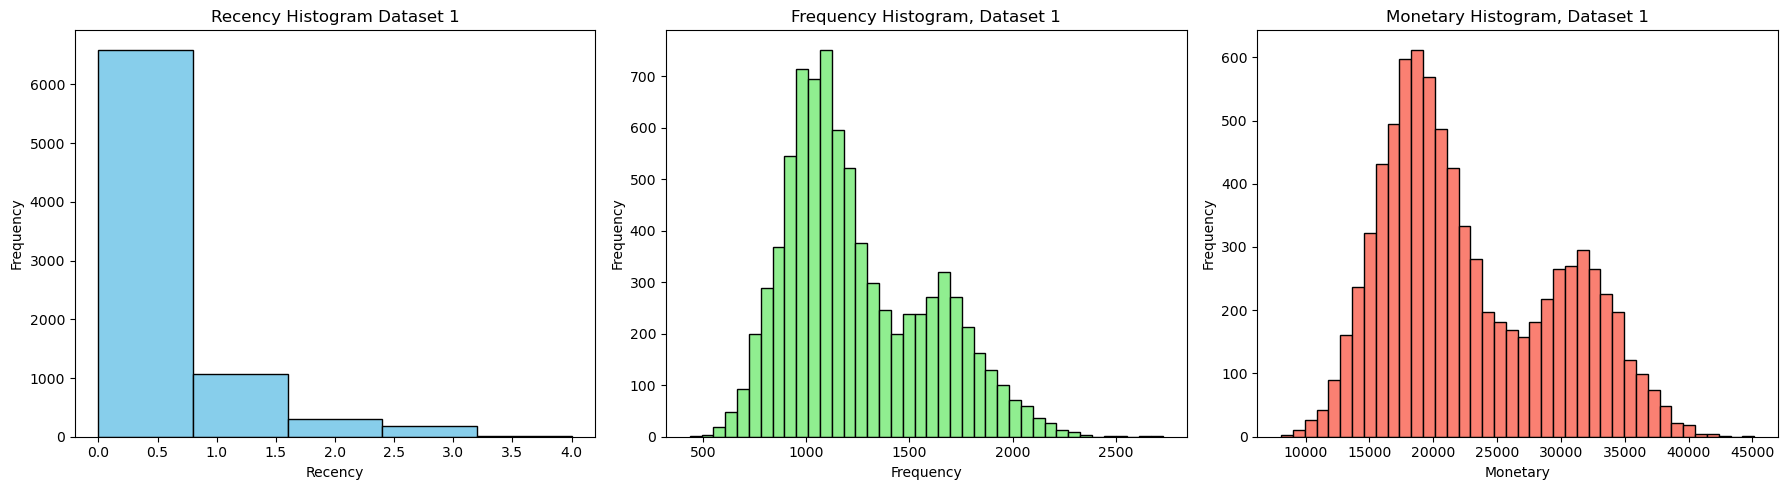

In [97]:
# Create histograms
fig, ax = plt.subplots(1, 3, figsize=(18, 5))  # Setup a figure with 3 subplots

# Recency Histogram
rfm_df['Recency'].plot(kind='hist', ax=ax[0], bins=5, color='skyblue', edgecolor='black')
ax[0].set_title('Recency Histogram Dataset 1')
ax[0].set_xlabel('Recency')
ax[0].set_ylabel('Frequency')

# Frequency Histogram
rfm_df['Frequency'].plot(kind='hist', ax=ax[1], bins=40, color='lightgreen', edgecolor='black')
ax[1].set_title('Frequency Histogram, Dataset 1')
ax[1].set_xlabel('Frequency')

# Monetary Histogram
rfm_df['Monetary'].plot(kind='hist', ax=ax[2], bins=40, color='salmon', edgecolor='black')
ax[2].set_title('Monetary Histogram, Dataset 1')
ax[2].set_xlabel('Monetary')

plt.tight_layout()  
plt.show()


Mulitmodal distribution for the frequency and monetary distributions

There are many ways to calculate the RFM scores. After exploring my data and researching papers on RFM analysis, I decided to use a scale of 1-4 rather than 1-5 (the common way) given there is only 8142 unique customers in the dataset. Moreover, I will be assigning the scores for Frequency and Monetary values through using quartiles, since there is enough variation in the data to be split into 4 groups. However, all unique accounts seemed to have completed transactions in the last 5 days of the year. Therefore, I will assign a highest score of 4 to all of those who spent money on the last day of the year, and give the accounts who spent in the last 5 days of the year a 3. 

In [37]:
bins = [0, 1, 2, 3, 5]
labels = [4, 3, 2, 1]

# Create 'R_Score' by binning 'Recency'
rfm_df['R_Score'] = pd.cut(rfm_df['Recency'], bins=bins, labels=labels, right=False)

# Convert 'R_Score' to integers
rfm_df['R_Score'] = rfm_df['R_Score']
rfm_df['F_Score'] = pd.qcut(rfm_df['Frequency'], 4, labels=[1, 2, 3, 4]).astype(int)
rfm_df['M_Score'] = pd.qcut(rfm_df['Monetary'], 4, labels=[1, 2, 3, 4]).astype(int)

# Calculate RFM_Score with the adjusted R_Score
rfm_df['RFM_Score'] = rfm_df['R_Score'].astype(str) + rfm_df['F_Score'].astype(str) + rfm_df['M_Score'].astype(str)

# Display the updated DataFrame to show the adjusted RFM Scores based on the corrected criteria
rfm_df


,user_id,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
0,1000,0,1710,28698.51,4,4,3,443
1,10000,3,917,20152.39,1,1,2,112
2,100000,0,1676,22087.82,4,4,3,443
3,100002,0,1397,21348.56,4,3,3,433
4,100019,0,938,30432.80,4,1,4,414
...,...,...,...,...,...,...,...,...
8137,99939,1,1283,18920.21,3,3,2,332
8138,99949,0,1003,13961.86,4,2,1,421
8139,99952,0,1287,34315.19,4,3,4,434
8140,99988,0,1259,30394.88,4,3,4,434


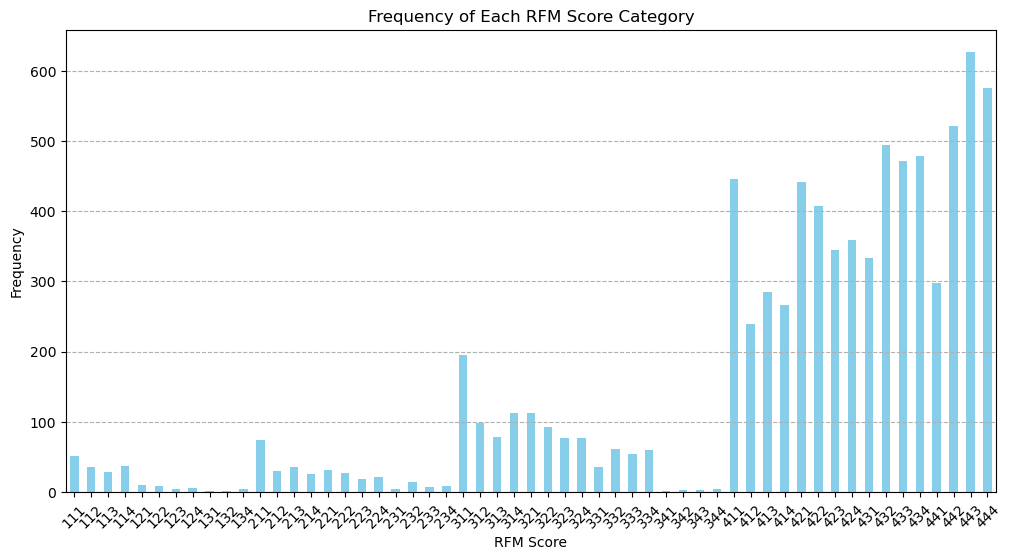

In [38]:
# Count the frequency of each RFM score category
rfm_score_counts = rfm_df['RFM_Score'].value_counts()

# Sort the RFM scores to ensure the histogram follows a logical order
rfm_score_counts = rfm_score_counts.sort_index()

# Plotting
plt.figure(figsize=(12, 6))
rfm_score_counts.plot(kind='bar', color='skyblue')
plt.title('Frequency of Each RFM Score Category')
plt.xlabel('RFM Score')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')

plt.show()


In [39]:
# Function to calculate the sum of digits in the RFM score
def sum_of_digits(score):
    return sum(int(digit) for digit in score)

# Adding a new column to the DataFrame for the sum of RFM score digits
rfm_df['Sum_of_Score'] = rfm_df['RFM_Score'].apply(sum_of_digits)

# Defining the sum ranges for each category
champion_value_sums = [11, 12]
high_value_sum_range = range(9, 11) 
middle_value_sum_range = range(7, 9)  
low_value_sum_range = range(5, 7)  

# Categorising based on sum
rfm_df['Customer_Segment_RFM'] = 'Low Value'  

# Applying categorisations
rfm_df.loc[rfm_df['Sum_of_Score'].isin(champion_value_sums), 'Customer_Segment_RFM'] = 'Champion Value'
rfm_df.loc[rfm_df['Sum_of_Score'].isin(high_value_sum_range), 'Customer_Segment_RFM'] = 'High Value'
rfm_df.loc[rfm_df['Sum_of_Score'].isin(middle_value_sum_range), 'Customer_Segment_RFM'] = 'Middle Value'
rfm_df['Customer_Segment_RFM'].value_counts()

High Value        2961
Middle Value      2263
Champion Value    1686
Low Value         1232
Name: Customer_Segment_RFM, dtype: int64

Reward customers based on their customer segment:
- Champions customers: reward them eg. early adopters of new products, will promote LLoyds and could send referrals
- High value customers: upsell higher value products eg. Club Lloyds platinum - could look into travel payments in next dataset 
- Medium value customers: Offer personalised recommendations, keep them engaged, provide helpful tips
- Low value: standard emails, do not spend two much money

## Scaling the data and creating an elbow plot

/Users/jessiebloom/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jessiebloom/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jessiebloom/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jessiebloom/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_

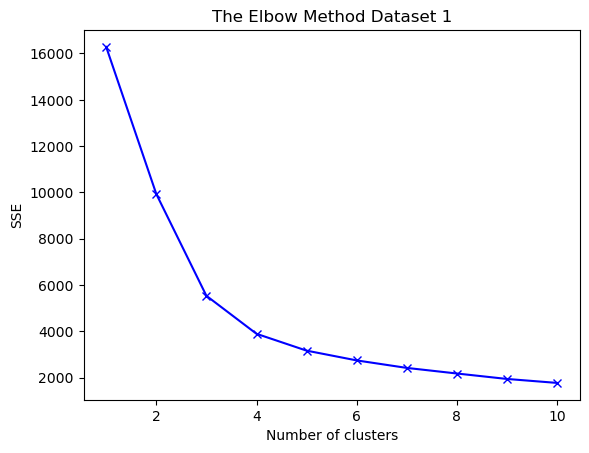

In [89]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_df[['Frequency', 'Monetary']])

sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(rfm_scaled)
    sse[k] = kmeans.inertia_  
    

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()), 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('The Elbow Method Dataset 1')
plt.show()


### Clustering the Frequency and Monetary columns with K-Means, GMM and DBSCAN 

In [98]:
#Run the K-means algorithm
# Choose the optimal number of clusters 
kmeans = KMeans(n_clusters=4)
labels_kmeans= kmeans.fit_predict(rfm_scaled)
rfm_df['Customer Segment Kmeans'] = labels_kmeans

# Accessing the centroids
centroids = kmeans.cluster_centers_

# Displaying the centroids
print("Centroids of each cluster:")
for i, centroid in enumerate(centroids):
    print(f"Cluster {i}: {centroid}")

# Gaussian Mixture Model
gmm = GaussianMixture(n_components=4)
labels_gmm = gmm.fit_predict(rfm_scaled)  
rfm_df['Customer Segment GMM'] = labels_gmm

# DBSCAN
dbscan = DBSCAN(eps=0.18, min_samples=85)
labels_dbscan = dbscan.fit_predict(rfm_scaled)  
rfm_df['DBSCAN Cluster'] = labels_dbscan

/Users/jessiebloom/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Centroids of each cluster:
Cluster 0: [1.27067286 1.49059632]
Cluster 1: [-0.58428025 -0.72986178]
Cluster 2: [-0.58576265  1.11627565]
Cluster 3: [ 1.24337438 -0.39295646]


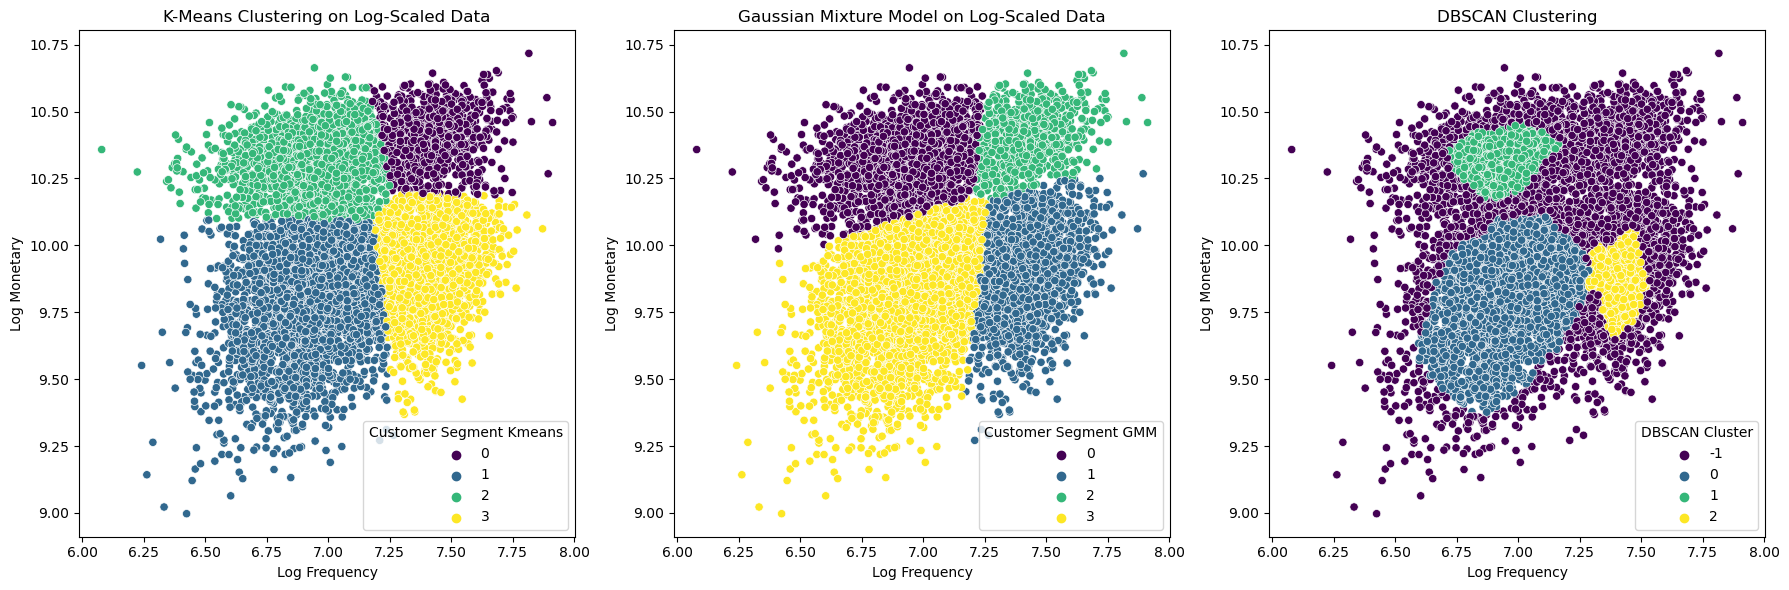

In [99]:
# Apply logarithmic scaling
rfm_df['Log Frequency'] = np.log1p(rfm_df['Frequency'])
rfm_df['Log Monetary'] = np.log1p(rfm_df['Monetary'])

# Plotting
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.scatterplot(data=rfm_df, x='Log Frequency', y='Log Monetary', hue='Customer Segment Kmeans', palette='viridis')
plt.title('K-Means Clustering on Log-Scaled Data')

plt.subplot(1, 3, 2)
sns.scatterplot(data=rfm_df, x='Log Frequency', y='Log Monetary', hue='Customer Segment GMM', palette='viridis')
plt.title('Gaussian Mixture Model on Log-Scaled Data')

plt.subplot(1, 3, 3)
sns.scatterplot(data=rfm_df, x='Log Frequency', y='Log Monetary', hue='DBSCAN Cluster', palette='viridis')
plt.title('DBSCAN Clustering')

plt.tight_layout()
plt.show()

In [95]:
# Calculating the percentage of noise points
noise_percentage = (labels_dbscan == -1).sum() / len(labels_dbscan) * 100

print(f"Percentage of noise points in DBSCAN: {noise_percentage:.2f}%")

Percentage of noise points in DBSCAN: 37.71%


### Comparing unsupervised learning clusters 

In [96]:
# Calculate metrics
# Silhouette scores
silhouette_kmeans = metrics.silhouette_score(rfm_scaled, labels_kmeans)
silhouette_gmm = metrics.silhouette_score(rfm_scaled, labels_gmm)
silhouette_dbscan = metrics.silhouette_score(rfm_scaled, labels_dbscan)

# Calinski-Harabasz Index
ch_kmeans = metrics.calinski_harabasz_score(rfm_scaled, labels_kmeans)
ch_gmm = metrics.calinski_harabasz_score(rfm_scaled, labels_gmm)
ch_dbscan = metrics.calinski_harabasz_score(rfm_scaled, labels_dbscan)

# Davies-Bouldin Index
db_kmeans = metrics.davies_bouldin_score(rfm_scaled, labels_kmeans)
db_gmm = metrics.davies_bouldin_score(rfm_scaled, labels_gmm)
db_dbscan = metrics.davies_bouldin_score(rfm_scaled, labels_dbscan)

# Print the results
print("Silhouette Scores:")
print("K-Means:", silhouette_kmeans)
print("GMM:", silhouette_gmm)
print("DBSCAN:", silhouette_dbscan)

print("\nCalinski-Harabasz Index:")
print("K-Means:", ch_kmeans)
print("GMM:", ch_gmm)
print("DBSCAN:", ch_dbscan)

print("\nDavies-Bouldin Index:")
print("K-Means:", db_kmeans)
print("GMM:", db_gmm)
print("DBSCAN:", db_dbscan)

Silhouette Scores:
K-Means: 0.4729160600402827
GMM: 0.4667524227674348
DBSCAN: 0.20269354705134288

Calinski-Harabasz Index:
K-Means: 7908.375293265157
GMM: 7603.146963891053
DBSCAN: 1846.0236123952116

Davies-Bouldin Index:
K-Means: 0.7609671199680088
GMM: 0.7628263461035029
DBSCAN: 1.484952274693978


1. Silhouette Score
The Silhouette Score is used to measure how similar an object is to its own cluster compared to other clusters. The score ranges from -1 to +1, where a high value indicates that objects are well matched to their own cluster and poorly matched to neighboring clusters.

2. Calinski-Harabasz Index
Also known as the Variance Ratio Criterion, this index measures the cluster cohesion and separation. It is defined as the ratio between the within-cluster dispersion and the between-cluster dispersion. Higher values generally indicate better-defined clusters.

3. Davies-Bouldin Index
This index measures the average similarity between each cluster and the cluster most similar to it. Lower values indicate that the clusters are more distinct from each other.